<a href="https://colab.research.google.com/github/abigelow1/NN_training_examples/blob/master/CIFAR_10_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a more advanced example of training a net. The caveat about MNIST is you can do really really well just based on linear transformations of the raw pixel values. Solving this problem with neural networks is almost overkill. Let's move into the realm of natural images. We're going to use a dataset called 'CIFAR 10' which consists of 10 categories of images ('bird', 'truck', etc.), each category has five thousand training images and 1000 test images. 

For more info: https://www.cs.toronto.edu/~kriz/cifar.html

For this example, we're going to utilize a GPU (thanks Google!) otherwise this would take way too long. 

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10('./home/',train=True,transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=4,shuffle=True)

test_set = torchvision.datasets.CIFAR10('./home/',train=False,transform=transform,download=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=4,shuffle=True)


Extracting ./home/cifar-10-python.tar.gz to ./home/
Files already downloaded and verified


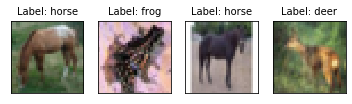

In [0]:
categories = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

diter = enumerate(train_loader)
idx,(ims,labels) = next(diter)

for i in range(len(labels)):
  plt.subplot(1,4,i+1)
  plt.imshow(np.transpose(ims[i]/2+0.5,(1,2,0))) #unnormalize images for viewing
  plt.xticks([]); plt.yticks([])
  plt.title("Label: %s" % categories[labels[i]],fontsize=10)

In [0]:
### Scratch work for finding output size of neural network ### 
a = nn.Conv2d(3,48,kernel_size=3)
b = nn.Conv2d(48,75,kernel_size=4)
c = nn.Conv2d(75,40,kernel_size=3)
ppp = nn.MaxPool2d(2)
input = torch.rand((4,3,32,32))

x = F.relu(ppp(a(input)))
print(x.size())

x = F.relu(ppp(b(x)))
print(x.size())

x = F.relu(ppp(c(x)))
print(x.size())

torch.Size([4, 48, 15, 15])
torch.Size([4, 75, 6, 6])
torch.Size([4, 40, 2, 2])


In [0]:
class Net(nn.Module):

  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,48,kernel_size=3)
    self.conv2 = nn.Conv2d(48,75,kernel_size=4)
    self.conv3 = nn.Conv2d(75,40,kernel_size=3) #output is 2x2x40
    self.pool = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(2*2*40,100)
    self.fc2 = nn.Linear(100,50)
    self.fc3 = nn.Linear(50,10)

  def forward(self,x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = F.relu(self.pool(self.conv3(x)))
    x = x.view(-1,2*2*40)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [0]:
device = torch.device("cuda:0")

net = Net()
net.to(device) #send to GPU 

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(),lr =0.001,momentum=0.9)

In [0]:
for epoch in range(3):

  running_loss = 0.0
  for i,data in enumerate(train_loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if i % 2000 == 1999:
      print('[Epoch: %d, trial: %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

print('Done training on GPU')

[Epoch: 1, trial:  2000] loss: 2.264
[Epoch: 1, trial:  4000] loss: 1.927
[Epoch: 1, trial:  6000] loss: 1.727
[Epoch: 1, trial:  8000] loss: 1.595
[Epoch: 1, trial: 10000] loss: 1.481
[Epoch: 1, trial: 12000] loss: 1.399
[Epoch: 2, trial:  2000] loss: 1.311
[Epoch: 2, trial:  4000] loss: 1.289
[Epoch: 2, trial:  6000] loss: 1.246
[Epoch: 2, trial:  8000] loss: 1.187
[Epoch: 2, trial: 10000] loss: 1.168
[Epoch: 2, trial: 12000] loss: 1.132
[Epoch: 3, trial:  2000] loss: 1.036
[Epoch: 3, trial:  4000] loss: 1.021
[Epoch: 3, trial:  6000] loss: 1.028
[Epoch: 3, trial:  8000] loss: 1.008
[Epoch: 3, trial: 10000] loss: 0.999
[Epoch: 3, trial: 12000] loss: 0.949
Done training on GPU


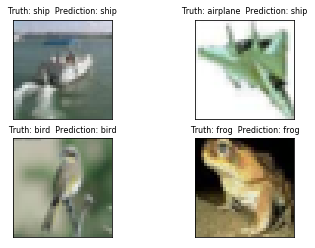

In [0]:
#Now test the performance of the net
#As with the other notebook, let's just test one batch first and visualize the results
#Let's get load it from the GPU now that we're done training
net = net.to(torch.device("cpu"))
net.eval()

diter = enumerate(test_loader)
idx,(ims,labels) = next(diter)

output = net(ims)
_,pred = torch.max(output,1)

for j in range(4):
  plt.subplot(2,2,j+1)
  plt.imshow(np.transpose(ims[j]/2+0.5,(1,2,0)))
  plt.xticks([]); plt.yticks([])
  plt.title('Truth: %s  Prediction: %s' %(categories[labels[j]], categories[pred[j]]),fontsize=8)

In [0]:
correct = list(0. for j in range(10))
total = list(0. for j in range(10))

with torch.no_grad():
  for i, data in enumerate(test_loader,0):

    inputs, labels = data
    output = net(inputs)
    _,pred = torch.max(output,1)

    for j in range(len(labels)):
      total[labels[j]] += 1
      correct[labels[j]] += pred[j] == labels[j]

print("Total accuracy: %.2f%%" %(float(100*sum(correct)/sum(total))))

for i in range(10):
  print("Accuracy for category %s:  %.2f%%" % (categories[i],float(100*correct[i]/total[i])))

Total accuracy: 66.48
Accuracy for category airplane:  60.10
Accuracy for category automobile:  85.60
Accuracy for category bird:  54.10
Accuracy for category cat:  39.20
Accuracy for category deer:  59.70
Accuracy for category dog:  68.20
Accuracy for category frog:  62.30
Accuracy for category horse:  72.90
Accuracy for category ship:  89.50
Accuracy for category truck:  73.20


Loading other models: 

In [0]:
import torchvision.models as models

net = models.alexnet(pretrained=True) #this will start a download of Alexnet's 700,000,000 weights 
net = models.vgg16(pretrained=False); #another cool net